<a href="https://colab.research.google.com/github/sikha2552/CNN_Evolution_UPC/blob/main/model_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To read:

https://www.eurasip.org/Proceedings/Eusipco/Eusipco2017/papers/1570347731.pdf

In [11]:
import sys  
sys.path.insert(0,'/content/drive/MyDrive/MY_Learnings/UPC-CNN_Evolution/ExplainBlobs-main/ExplainBlobs-main/')
import generator

In [12]:
from skimage import data, measure
import skimage as sk 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import minmax_scale
from skimage.util import random_noise
from skimage.filters import gaussian
from skimage import measure
import tensorflow as tf
import keras
from keras import layers

import generator
import explainabilityModels

In [22]:
#hyperparameters and blank image and label generation
N = 6000
size = 64
big_blob_size = 8
big_blob_range = 2
labels = np.random.randint(3, size = N)
imgs = np.zeros((size, size, N))


In [23]:
#fill array with corresponding images
# the function generate_new_blob_img is imported from our generator file. In order to replicate the results of the paper, use exactly these parameters
for i in range(N):
    if labels[i] == 0:
        x = generator.generate_new_blob_img(ellipse=True, size=size,num_big_blobs=4)
    elif labels[i] == 1:
        x = generator.generate_new_blob_img(ellipse = False, size = size, num_big_blobs=4)
    elif labels[i] == 2:
        x = generator.generate_new_blob_img(ellipse= False, size = size, num_big_blobs=0)
    imgs[:,:,i] = x

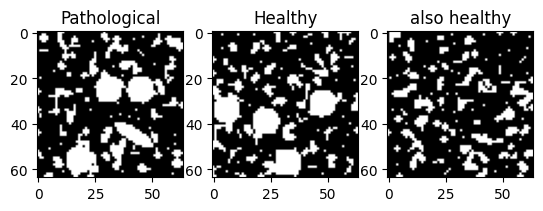

In [24]:
#display one pathological and one healthy image
fig, ax = plt.subplots(1,3)

path_img = imgs[:,:,np.where(labels == 0)[0][0]]
healthy_img = imgs[:,:,np.where(labels ==1)[0][0]]
healthy2_img = imgs[:,:,np.where(labels ==2)[0][0]]

ax[0].imshow(path_img, cmap=plt.cm.gray)
ax[1].imshow(healthy_img, cmap=plt.cm.gray)
ax[2].imshow(healthy2_img, cmap = plt.cm.gray)

ax[0].set_title("Pathological");
ax[1].set_title("Healthy");
ax[2].set_title('also healthy');

In [25]:
#prepare data for training
from sklearn.model_selection import train_test_split
X = np.expand_dims(imgs, -1)
X = np.transpose(X, (2,1,0,3))
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X.shape

(6000, 64, 64, 1)

In [26]:
# Model hyperparameters
num_classes = 3
input_shape = (size, size, 1)
batch_size = 64
epochs = 40
conv_size=(3,3)
save = False #if running the entire notebook, always set this to false! otherwise you might overwrite something if you forget to change the name of the file
# convert class vectors to binary class matrices
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

## The model


In [27]:
#create model
#the model is a standard three layer CNN architecture. If this happens to not work on your dataset, some useful things might include:

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=conv_size, activation="relu", padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=conv_size, activation="relu", padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=conv_size, activation="relu", padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(name="features"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                        

In [ ]:
#utility to plot model
tf.keras.utils.plot_model(model, to_file='model.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [28]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
epochs=1

model.fit(X_train, y_train_cat, batch_size=batch_size, epochs=epochs, validation_split=0.1)


57/57 [==============================] - 54s 914ms/step - loss: 10.7409 - accuracy: 0.3300 - val_loss: 5.6935 - val_accuracy: 0.3010


In [ ]:
#run this if you want to save the model and have set save to True. 
save=True
if save:
    model.save("/content/drive/MyDrive/MY_Learnings/UPC-CNN_Evolution/ExplainBlobs-main/ExplainBlobs-main/models/model_epoch3_val_44.53.h5")

# Model evaluation 



In [ ]:
model.load_weights("/content/drive/MyDrive/MY_Learnings/UPC-CNN_Evolution/ExplainBlobs-main/ExplainBlobs-main/models/model_epoch1_val_36.82.h5")

In [ ]:
# Validate model
from sklearn.metrics import classification_report

label_names = ['Pathological', 'Healthy', 'also healthy']

score = model.evaluate(X_test, y_test_cat, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

y_test_pred_DL_full = np.argmax(model.predict(X_test),axis=1) # convert back from one-hot categorical encoding to integers
print(classification_report(y_test, y_test_pred_DL_full, target_names=label_names))

Test loss: 5.486663341522217
Test accuracy: 0.44292929768562317
62/62 [==============================] - 9s 141ms/step
              precision    recall  f1-score   support

Pathological       0.00      0.00      0.00       674
     Healthy       0.41      0.65      0.50       654
also healthy       0.48      0.69      0.57       652

    accuracy                           0.44      1980
   macro avg       0.30      0.45      0.36      1980
weighted avg       0.29      0.44      0.35      1980



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import ipywidgets as widgets
#get array or predictions for test set

predicted_classes = model.predict(X_test)
predicted_classes = np.argmax(predicted_classes, axis=1)
label_picker = widgets.Dropdown(
    options=[('Pathological', 0), ('Healthy', 1), ('also healthy', 2)],
    value=0,
    description='True Label:',
)
pred_picker = widgets.Dropdown(
    options=[('Pathological', 0), ('Healthy', 1), ('also healthy', 2)],
    value=0,
    description='Predicted Label:',
)
#pick what you want to see
display(label_picker)
display(pred_picker)


62/62 [==============================] - 7s 107ms/step


Dropdown(description='True Label:', options=(('Pathological', 0), ('Healthy', 1), ('also healthy', 2)), value=…

Dropdown(description='Predicted Label:', options=(('Pathological', 0), ('Healthy', 1), ('also healthy', 2)), v…

In [ ]:
#show image
img = X_test[np.where((y_test == label_picker.value) & (predicted_classes == pred_picker.value))[0][0]]
label = pred_picker.value
plt.imshow(img)

In [34]:
#Load images to visualize the gradcam
img=X_test[8] # 0 healthy, 1- healthy,8-Pathological

In [35]:
#generate heatmap with keras implmentation of gradcam
heatmap = explainabilityModels.make_gradcam_heatmap(img, model)

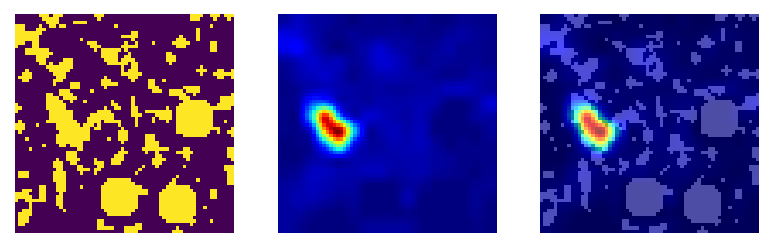

In [36]:
fig, ax = plt.subplots(1,3)
fig.set_dpi(150)
fig.tight_layout

ax[0].imshow(img)
ax[1].imshow(heatmap, cmap = 'jet')
ax[2].imshow(img, cmap = 'gray')
ax[2].imshow(heatmap, alpha = 0.7, cmap='jet')

for a in ax:
  a.axis('off')


In [18]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82816 sha256=60eb461d424ff9917a3b8513dee50a07156b0a6b25dce11e00e64bbe65ec8b48
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55622 sha256=0603fcc083847ee4529b0469a7bca61dae3fa13f4601c3985b01acd2072c3451
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [ ]:
import numpy as np
import umap.umap_ as umap
import matplotlib.pyplot as plt

### Define the model for feature extraction

In [ ]:

from tensorflow.keras.models import Model

#base_model = keras.models.load_model(folder_data + '/model_saved')

model_FE = Model(inputs=model.input, outputs=model.get_layer('features').output)
model_FE.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 64)       256 

In [ ]:
df_train = model_FE.predict(X_train) # extract Deep trained features from text subset

126/126 [==============================] - 13s 102ms/step


In [ ]:
umap_df = umap.UMAP(n_neighbors=15).fit_transform(df_train.squeeze())

<ipython-input-33-b72e10b3b5ff>:3: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.scatterplot(x = umap_df[:,0], y = umap_df[:,1], hue=y_train, palette = sns.hls_palette(10), legend = 'full');


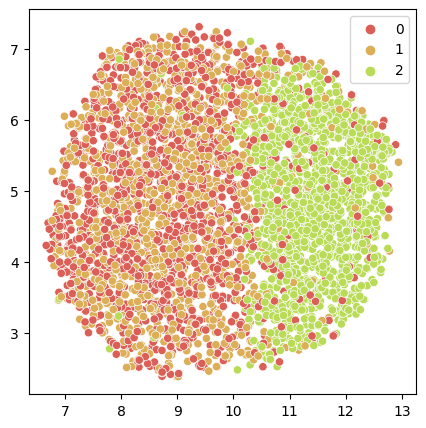

In [ ]:
import seaborn as sns
fig = plt.figure(figsize=(5,5))
sns.scatterplot(x = umap_df[:,0], y = umap_df[:,1], hue=y_train, palette = sns.hls_palette(10), legend = 'full');
#filename = f'/content/drive/MyDrive/MY_Learnings/UPC-CNN_Evolution/UMAP_epochs/scatter_plot_epoch_{epochs}.png'
plt.savefig( f'/content/drive/MyDrive/MY_Learnings/UPC-CNN_Evolution/UMAP_epochs/scatter_plot_epoch_{epochs}.png', dpi=300)

##Train the model and save weights in each epoch , Visualize Umap in each epoch

In [11]:
import umap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
import os
# Create a new model with the features layer as the output
features_model = keras.Model(inputs=model.input, outputs=model.get_layer("features").output)

# Define a list to store UMAP visualizations
umap_plots = []

# Define the number of epochs
num_epochs =10
# Create a directory to store the weights and UMAP visualizations
weights_dir = '/content/drive/MyDrive/MY_Learnings/UPC-CNN_Evolution/Weights_epochs'
Umap_dir='/content/drive/MyDrive/MY_Learnings/UPC-CNN_Evolution/UMAP_epochs'
os.makedirs(weights_dir, exist_ok=True)
for epoch in range(num_epochs):
   
    # Define the checkpoint filepath for the current epoch
    checkpoint_filepath = os.path.join(
        weights_dir, f'weights_{epoch + 41:02d}.h5')
    # Define the ModelCheckpoint callback for the current epoch
    checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        save_best_only=False,
        save_freq='epoch'
    )
    # Train your model for one epoch
    history=model.fit(X_train, y_train_cat, batch_size=batch_size, epochs=1, validation_split=0.1,callbacks=[checkpoint_callback])
    # Obtain the features for your data
    features = features_model.predict(X_train)
    
    # Perform UMAP dimensionality reduction
    umap_emb = umap.UMAP().fit_transform(features)
    
    # Plot the UMAP visualization
    plt.scatter(umap_emb[:, 0], umap_emb[:, 1], c=np.argmax(y_train_cat, axis=1))
    #plt.colorbar()
    plt.axis('off')
    plt.title(f"UMAP Visualization - Epoch {epoch+41}")
    
    # Save the UMAP visualization
    umap_plot_filepath =  os.path.join(
        Umap_dir,  f"umap_visualization_epoch_{epoch+41}.png")
    plt.savefig(umap_plot_filepath)
    # Clear the plot for the next epoch
    plt.clf()
    # Append the UMAP visualization filepath to the list
    umap_plots.append(umap_plot_filepath)
    #Plot using sns
    sns_plot_dir='/content/drive/MyDrive/MY_Learnings/UPC-CNN_Evolution/UMAP_epochs/SNS_plots'
    sns.scatterplot(x = umap_emb[:, 0], y = umap_emb[:, 1], hue=y_train, palette = sns.hls_palette(10), legend = 'full');
    sns_plot_filepath =  os.path.join(
        sns_plot_dir,  f"umap_visualization_epoch_{epoch+21}.png")
    plt.savefig(sns_plot_filepath)
    plt.savefig(  sns_plot_filepath, dpi=300)
    # Clear the plot for the next epoch
    plt.clf()

# Print the list of UMAP visualization filepaths
print("UMAP Visualizations:")
for umap_plot_filepath in umap_plots:
    print(umap_plot_filepath)

#Generate gradcams and store

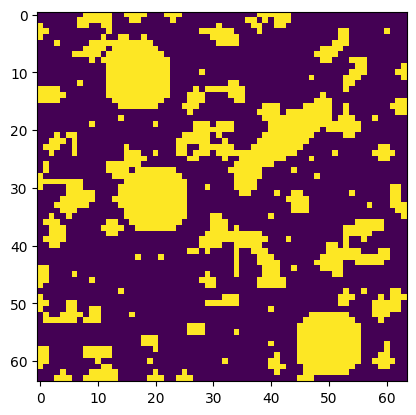

In [28]:
plt.imshow(path_img)

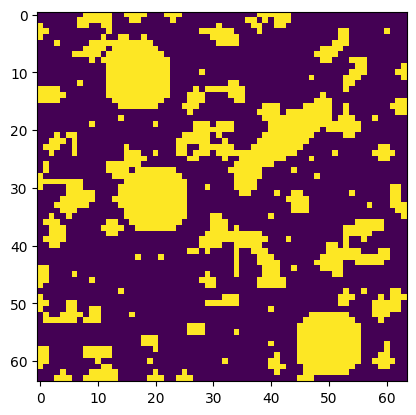

In [46]:
#Select the image
#Load images to visualize the gradcam
img=path_img #X_test[8] # 0 healthy, 1- healthy,8-Pathological
#img=healthy_img
#img=healthy2_img
plt.imshow(img)

In [47]:
weight_dir='/content/drive/MyDrive/MY_Learnings/UPC-CNN_Evolution/UMAP_epochs'
# Define the directory to save the Grad-CAM results
gradcam_dir = '/content/drive/MyDrive/MY_Learnings/UPC-CNN_Evolution/Gradcam/1_pathological'
i=1
for filename in os.listdir(weights_dir):
    # Load the weights
    weights_path = os.path.join(weights_dir, filename)
    model.load_weights(weights_path)
    #generate heatmap with keras implmentation of gradcam
    heatmap = explainabilityModels.make_gradcam_heatmap(img, model)
    plt.imshow(img, cmap = 'gray')
    plt.imshow(heatmap, alpha = 0.7, cmap='jet')
    plt.axis('off')
    plt.title(f"Gradcam - Epoch {i}")
    
     # Save the UMAP visualization
    grad_filepath =  os.path.join(
        gradcam_dir,  f"Gradcam_{i}.png")
    plt.savefig( grad_filepath)
    # Clear the plot for the next epoch
    plt.clf()
    i=i+1


<Figure size 640x480 with 0 Axes>

## silhouette_score

In [ ]:
import umap
import os
from sklearn.metrics import silhouette_score
weights_dir='/content/drive/MyDrive/MY_Learnings/UPC-CNN_Evolution/Weights_epochs'

# Assuming you have your data stored in a variable called `X`
i=1
for filename in os.listdir(weights_dir):
    # Load the weights
    weights_path = os.path.join(weights_dir, filename)
    model.load_weights(weights_path)
  # Create a new model with the features layer as the output
    features_model = keras.Model(inputs=model.input, outputs=model.get_layer("features").output)
    features = features_model.predict(X_train)
    
    # Perform UMAP dimensionality reduction
    umap_emb = umap.UMAP().fit_transform(features)
# Calculate the Silhouette Score
    silhouette_avg = silhouette_score(umap_emb,y_train)

    print(f"Silhouette Score Epoch {i}: {silhouette_avg}")
    i=i+1

## Davies-Bouldin Index

In [ ]:
import umap
import os
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

weights_dir='/content/drive/MyDrive/MY_Learnings/UPC-CNN_Evolution/Weights_epochs'

# Assuming you have your data stored in a variable called `X`
i=1
dbi_values=[]
for filename in os.listdir(weights_dir):
    # Load the weights
    weights_path = os.path.join(weights_dir, filename)
    model.load_weights(weights_path)
  # Create a new model with the features layer as the output
    features_model = keras.Model(inputs=model.input, outputs=model.get_layer("features").output)
    features = features_model.predict(X_train)
    
    # Perform UMAP dimensionality reduction
    umap_emb = umap.UMAP().fit_transform(features)
    # Calculate the Davies-Bouldin Index: Lower the values Better the clustering
    dbi= davies_bouldin_score(umap_emb,y_train)
    dbi_values.append(dbi)
    print(f"DBI Epoch {i}: {dbi}")
    i=i+1
    # Save the DBI values to an Excel file
dbi_df = pd.DataFrame({'Epoch': range(1, len(dbi_values) + 1), 'DBI': dbi_values})
dbi_df.to_excel('/content/drive/MyDrive/MY_Learnings/UPC-CNN_Evolution/dbi_values.xlsx', index=False)

## Inter Class and Intra Class Distance

In [ ]:
import umap
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
import os
from tensorflow.keras.models import Model

intra_class_distances = []
inter_class_distances = []
weights_dir='/content/drive/MyDrive/MY_Learnings/UPC-CNN_Evolution/Weights_epochs'
for filename in os.listdir(weights_dir):
    # Load the weights
    weights_path = os.path.join(weights_dir, filename)
    model.load_weights(weights_path)
    # Create a new model with the features layer as the output
    features_model = keras.Model(inputs=model.input, outputs=model.get_layer("features").output)
    features = features_model.predict(X_train)
    
    # Perform UMAP dimensionality reduction
    #umap_emb = umap.UMAP().fit_transform(features)
    embeddings =umap.UMAP().fit_transform(features)
    labels = y_train
    unique_classes = np.unique(labels)

    # Calculate intra-class distances
    intra_distances = []
    for class_label in unique_classes:
        class_indices = np.where(labels == class_label)[0]
        class_embeddings = embeddings[class_indices]
        intra_distance = np.mean(euclidean_distances(class_embeddings))
        intra_distances.append(intra_distance)
    intra_class_distances.append(np.mean(intra_distances))

    # Calculate inter-class distances
    inter_distances = []
    for i in range(len(unique_classes)):
        for j in range(i + 1, len(unique_classes)):
            class_i_indices = np.where(labels == unique_classes[i])[0]
            class_j_indices = np.where(labels == unique_classes[j])[0]
            class_i_embeddings = embeddings[class_i_indices]
            class_j_embeddings = embeddings[class_j_indices]
            inter_distance = np.mean(euclidean_distances(class_i_embeddings, class_j_embeddings))
            inter_distances.append(inter_distance)
    inter_class_distances.append(np.mean(inter_distances))

# Print the intra-class and inter-class distances for each epoch
for epoch in range(50):
    print(f"Epoch {epoch+1}: Intra-class distance = {intra_class_distances[epoch]}, Inter-class distance = {inter_class_distances[epoch]}")

    # Save the DBI values to an Excel file
dbi_df = pd.DataFrame({'Epoch': range(1, 50 + 1), 'Intra-class distance': intra_class_distances,'Inter-class distance':inter_class_distances})
dbi_df.to_excel('/content/drive/MyDrive/MY_Learnings/UPC-CNN_Evolution/Class_distances.xlsx', index=False)


## DUNN - Index

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial.distance import cdist

def calculate_dunn_index(embeddings, labels):
    num_clusters = len(np.unique(labels))
    intra_cluster_distances = []
    for cluster_label in range(num_clusters):
        cluster_indices = np.where(labels == cluster_label)[0]
        cluster_embeddings = embeddings[cluster_indices]
        intra_distance = np.mean(cdist(cluster_embeddings, cluster_embeddings))
        intra_cluster_distances.append(intra_distance)

    inter_cluster_distances = cdist(embeddings, embeddings)
    np.fill_diagonal(inter_cluster_distances, np.inf)
    min_inter_cluster_distance = np.min(inter_cluster_distances)
    
    dunn_index = min_inter_cluster_distance / np.max(intra_cluster_distances)
    return dunn_index

# Assuming you have UMAP embeddings for each epoch stored in a list called umap_embeddings
# Assuming you have corresponding class labels for each epoch stored in a list called class_labels

dunn_indices = []
i=1
for filename in os.listdir(weights_dir):
    # Load the weights
    weights_path = os.path.join(weights_dir, filename)
    model.load_weights(weights_path)
  # Create a new model with the features layer as the output
    features_model = keras.Model(inputs=model.input, outputs=model.get_layer("features").output)
    features = features_model.predict(X_train)
    
    # Perform UMAP dimensionality reduction
    umap_emb = umap.UMAP().fit_transform(features)
    labels = y_train[i]
    i+1
    dunn_index = calculate_dunn_index(embeddings, labels)
    dunn_indices.append(dunn_index)

# Print the Dunn Index for each epoch
for epoch in range(len(umap_emb)):
    print(f"Epoch {epoch+1}: Dunn Index = {dunn_indices[epoch]}")

   # Save the DBI values to an Excel file
dunnI_df = pd.DataFrame({'Epoch': range(1, 50 + 1), 'DunnIndex': dunn_indices)
dunnI_df.to_excel('/content/drive/MyDrive/MY_Learnings/UPC-CNN_Evolution/Dunn_indices.xlsx', index=False)

## Save the Umap Embeddings

In [ ]:
import umap
import os
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

weights_dir='/content/drive/MyDrive/MY_Learnings/UPC-CNN_Evolution/Weights_epochs'
UMAP_EMDB=[]
# Assuming you have your data stored in a variable called `X`
i=1
dbi_values=[]
for filename in os.listdir(weights_dir):
    # Load the weights
    weights_path = os.path.join(weights_dir, filename)
    model.load_weights(weights_path)
  # Create a new model with the features layer as the output
    features_model = keras.Model(inputs=model.input, outputs=model.get_layer("features").output)
    features = features_model.predict(X_train)
    
    # Perform UMAP dimensionality reduction
    umap_emb = umap.UMAP().fit_transform(features)
    UMAP_EMDB.append(umap_emb)
umap_df = pd.DataFrame({ UMAP_EMDB})
umap_df.to_excel('/content/drive/MyDrive/MY_Learnings/UPC-CNN_Evolution/umap_embedding.xlsx', index=False)

126/126 [==============================] - 13s 99ms/step


In [ ]:
!pip install tf_keras_vis

In [ ]:
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
#generate tf keras vis gradcam and gradcam++ heatmaps
gradcam = GradcamPlusPlus(model, model_modifier=ReplaceToLinear(), 
            clone=True)
gradcam2 = Gradcam(model, model_modifier=ReplaceToLinear(), clone=True)
cam = gradcam(CategoricalScore(labels), img).squeeze()
cam2 = gradcam2(CategoricalScore(labels), img).squeeze()

fig, ax = plt.subplots(2,2)
fig.set_size_inches((10,10))
ax[0][0].imshow(cam, cmap = 'jet')
ax[0][1].imshow(img, cmap = 'gray')
ax[0][1].imshow(cam, cmap = 'jet', alpha = 0.7)

ax[1][0].imshow(cam2, cmap = 'jet')
ax[1][1].imshow(img, cmap = 'gray')
ax[1][1].imshow(cam2, cmap = 'jet', alpha = 0.7)


4/4 [==============================] - 0s 3ms/step


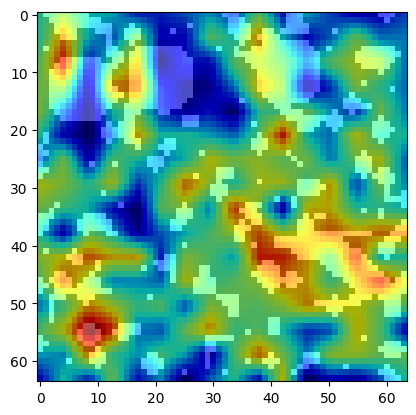

In [ ]:
from tf_keras_vis.scorecam import Scorecam
#genrate scorecam heatmap
scoreCam = Scorecam(model)

sC = scoreCam(CategoricalScore(0), img).squeeze()

plt.imshow(img, cmap = 'gray')
plt.imshow(sC, cmap = 'jet', alpha = 0.7)

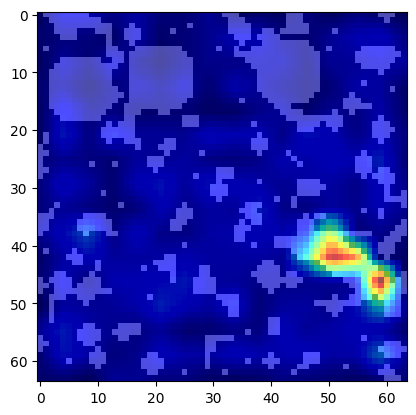

In [ ]:
from tf_keras_vis.layercam import Layercam

lC = Layercam(model, model_modifier=ReplaceToLinear(), clone=True)
lC_img = lC(CategoricalScore(0), img).squeeze()

plt.imshow(img, cmap='gray')
plt.imshow(lC_img, cmap ='jet', alpha = 0.7)